In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve



In [12]:
# Load data
data = pd.read_csv('Close2AdmitDataWithRV.csv')

# Clean data
data = data.dropna(subset=['RV Dysfunction'])
data = data[data['RV Dysfunction'] != '0']

''' Select features
columns_to_exclude = ['patid', 'patkey', 'TTEDate', 'AVr_str', 'PVr_str', 'TVr_str', 'MVr_str']
'''

" Select features\ncolumns_to_exclude = ['patid', 'patkey', 'TTEDate', 'AVr_str', 'PVr_str', 'TVr_str', 'MVr_str']\n"

In [6]:
import numpy as np
import pandas as pd

def calculate_cardiac_indices(df):
    """
    Calculate cardiac indices based on available variables according to the provided formula sheet.
    
    Parameters:
    df (pandas.DataFrame): Input dataframe with RHC and TTE variables
    
    Returns:
    pandas.DataFrame: Dataframe with additional cardiac indices columns
    """
    # Convert LVIDd from mm to mL (assuming LVIDd is in mm, convert to cm, then use volume formula)
    df['LVIDd_cm'] = df['LVIDd'] / 10  # Convert mm to cm
    df['LVEDV'] = (4/3) * np.pi * (df['LVIDd_cm']/2) ** 3  # Volume calculation

    # Convert LVEF from percentage to fraction
    df['LVEF_tte'] = df['LVEF_tte'] * 0.01  

    # Calculate Left Ventricle Stroke Volume
    df['LVSV'] = df['LVEDV'] * df['LVEF_tte']

    # Mean Blood Pressure calculation
    df['mean_BP'] = (2/3 * df['NIBPd_vitals']) + (1/3 * df['NIBPs_vitals'])

    # Estimate Body Surface Area (BSA) using DuBois formula
    df['BSA'] = 0.007184 * (df['Weight'] ** 0.425) * (df['Height'] ** 0.725)

    # Left Ventricle Stroke Work Index (LVSWI)
    df['LVSWI'] = df['LVSV'] * (df['mean_BP'] - df['PCW']) * 0.0136 / df['BSA']

    # Right Ventricle Stroke Work Index (RVSWI)
    df['PAm'] = (df['PAs'] + 2 * df['PAd']) / 3
    df['RVSWI'] = df['LVSV'] * (df['PAm'] - df['RAm']) * 0.0136 / df['BSA']

    # LV Stiffness = stress / strain
    df['stress'] = df['PCW'] * (df['LVIDd_cm']/2) / (2 * df['IVSd'])
    df['strain'] = (df['LVIDd_cm'] - df['LVIDs']) / df['LVIDs']
    df['LV_stiffness'] = df['stress'] / df['strain']

    # Passive Cardiac Index = RAP * CO / (LVEDP * BSA), where LVEDP = PCW
    df['Passive_Cardiac_Index'] = df['RAm'] * df['CO_fick'] / (df['PCW'] * df['BSA'])

    return df


In [15]:
missing_percentages = data.isnull().mean() * 100
data = calculate_cardiac_indices(data)
#data = data.drop(columns=columns_to_exclude)
# Identify columns with more than 20% missing data
columns_to_drop = missing_percentages[missing_percentages > 20].index

# Drop these columns from the dataset
data = data.drop(columns=columns_to_drop)

# Display the columns dropped
print(f"Columns dropped: {columns_to_drop.tolist()}")

Columns dropped: []


In [16]:
#drop patients where more than 20% missing
missing_percentage = data.isnull().mean(axis=1)

# Keep only the rows where missing percentage is <= 0.2 (20%)
df_cleaned = data[missing_percentage <= 0.2]

# Reset index if desired
data = df_cleaned.reset_index(drop=True)

In [17]:
# Convert 'Birthday' to Age
if 'Birthday' in data.columns:
    data['Birthday'] = pd.to_datetime(data['Birthday'], format="%d-%b-%y", errors='coerce')
    data = data.dropna(subset=['Birthday'])  # Drop rows where Birthday conversion failed

    today = pd.to_datetime('today')
    data['Age'] = (today - data['Birthday']).dt.days / 365.25  

data = data.drop(columns=['Birthday'], errors='ignore')

# Select numerical features for X
X = data.select_dtypes(include=[np.number]).drop(columns=['RV Dysfunction'], errors='ignore')
#print(X.head())

In [18]:
from sklearn.impute import KNNImputer
# Initialize the KNN imputer
# You can adjust n_neighbors as needed
X = X.replace([np.inf, -np.inf], np.nan)

knn_imputer = KNNImputer(n_neighbors=5)

# Get the feature names for later use
feature_names = X.columns

# Apply KNN imputation to your features
X_imputed = knn_imputer.fit_transform(X)

# Convert back to DataFrame to preserve column names
X = pd.DataFrame(X_imputed, columns=feature_names)

# Then continue with standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
# Encode target variable into binary labels
Y = data['RV Dysfunction'].replace({
    'Moderate': 'High Dysfunction',
    'Severe': 'High Dysfunction',
    'Normal': 'Low Dysfunction',
    'Mild': 'Low Dysfunction'
})

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_encoded, test_size=0.2, random_state=42)


In [20]:
print("Class distribution:", np.bincount(y_train))
print("Classes",np.unique(Y) )

Class distribution: [131 219]
Classes ['High Dysfunction' 'Low Dysfunction']


In [21]:
def train_and_evaluate(model, model_name, X_train, Y_train, X_test, Y_test):
    """
    Trains and evaluates a classification model.
    Prints classification report, confusion matrix, and calculates ROC AUC.
    """
    print(f"\n--- {model_name} ---")

    # Train the model
    model.fit(X_train, Y_train)

    # Make predictions
    Y_pred = model.predict(X_test)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(Y_test, Y_pred))

    # Print confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(Y_test, Y_pred)
    cm_df = pd.DataFrame(cm)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Calculate ROC AUC
    if hasattr(model, "predict_proba"):  # Ensure the model supports probability predictions
        Y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1
        roc_auc = roc_auc_score(Y_test, Y_pred_proba)

        print(f"ROC AUC: {roc_auc:.4f}")

        # Plot ROC Curve
        fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
    
    return model


--- Logistic Regression ---

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.56      0.53        39
           1       0.61      0.55      0.58        49

    accuracy                           0.56        88
   macro avg       0.56      0.56      0.56        88
weighted avg       0.56      0.56      0.56        88


Confusion Matrix:


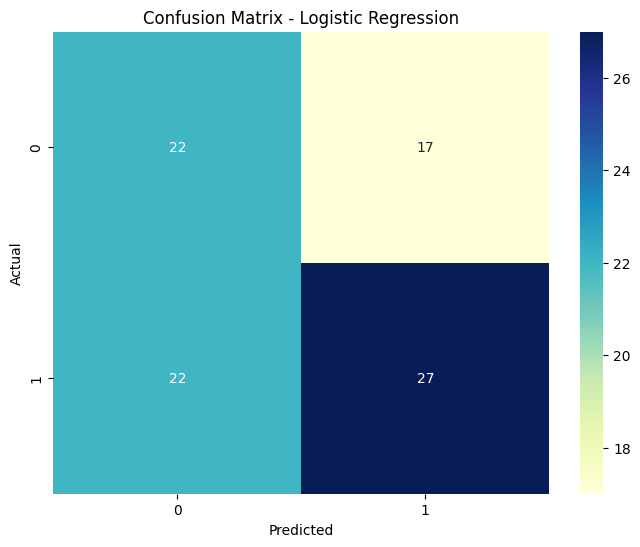

ROC AUC: 0.6049


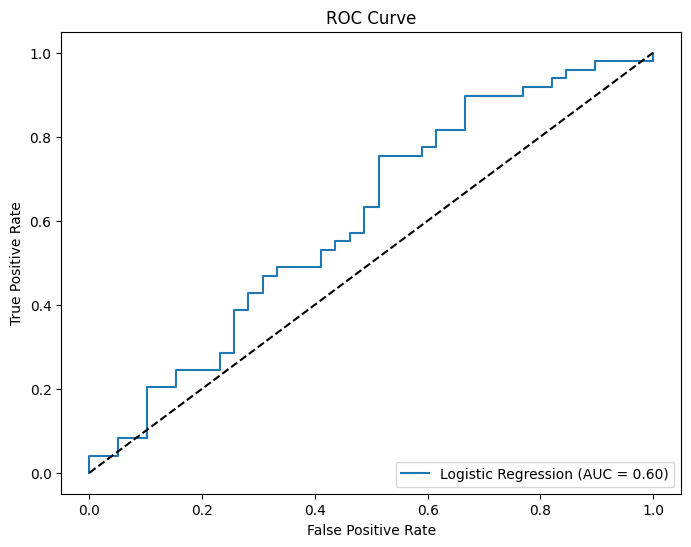


Cross-Validation Scores: [0.54545455 0.53409091 0.5        0.59770115 0.52873563]
Mean CV Score: 0.5411964472309301
Standard Deviation of CV Scores: 0.03198068360401683

Top 10 Most Important Features:
                  feature  importance
4                 CO_fick    0.658031
8                     PAs    0.502564
10                    RVs    0.497528
6                    PCWa    0.436689
5                     PCW    0.374927
42                  LVSWI    0.370465
37               LVIDd_cm    0.357211
25                  LVIDd    0.357211
3                   CO_td    0.343193
45                 stress    0.331368
32                   AVpg    0.324270
48  Passive_Cardiac_Index    0.305513
16              HR_vitals    0.296137
47           LV_stiffness    0.290612
27               LVEF_tte    0.289964
12                    RVd    0.289331
28                   IVSd    0.264717
30                    LAd    0.257344
36                    Age    0.247909
46                 strain    0.236673

/var/folders/dz/fbr6_yrs1qd7cqdgs7l6dw780000gn/T/ipykernel_87138/377127690.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance.head(20), palette='viridis')


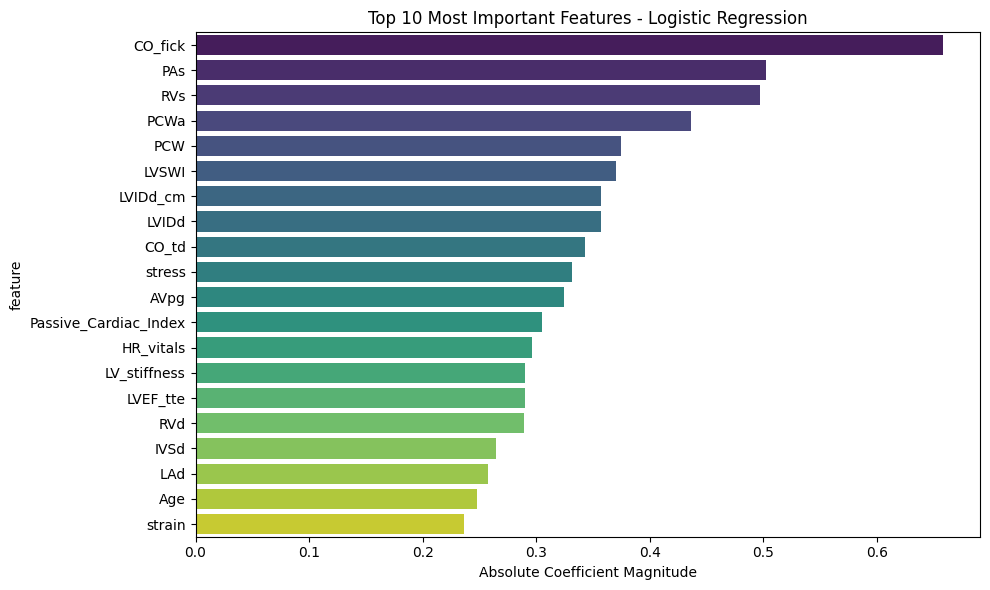

In [22]:
logistic_model = LogisticRegression(
    random_state=42,  # For reproducibility
    max_iter=1000,    # Increase max iterations to ensure convergence
    class_weight='balanced'  # Handle class imbalance
)

# Train and evaluate Logistic Regression
logistic_regression_model = train_and_evaluate(
    logistic_model, 
    "Logistic Regression", 
    X_train, 
    y_train, 
    X_test, 
    y_test
)

# Optional: Perform cross-validation
cv_scores = cross_val_score(logistic_model, X_scaled, Y_encoded, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
print("\nCross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())

# Optional: Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(logistic_regression_model.coef_[0])
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(20))

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20), palette='viridis')
plt.title('Top 10 Most Important Features - Logistic Regression')
plt.xlabel('Absolute Coefficient Magnitude')
plt.tight_layout()
plt.show()